# Non-negative Matrix Factorization (NMF)

[![Slides](https://img.shields.io/badge/🦌-ReHLine-blueviolet)](https://rehline-python.readthedocs.io/en/latest/)

Non-negative Matrix Factorizaation (NMF) solves the following optimiation problem:

$$
  \min_{\substack{
      \mathbf{P} \in \mathbb{R}^{n \times k}\ 
      \pmb{\alpha} \in \mathbb{R}^n \\
      \mathbf{Q} \in \mathbb{R}^{m \times k}\ 
      \pmb{\beta} \in \mathbb{R}^m
  }} 
  \left[
      \sum_{(u,i)\in \Omega} C \cdot \phi(r_{ui}, \ \mathbf{p}_u^T \mathbf{q}_i + \alpha_u + \beta_i) 
  \right]  
  + 
  \left[ 
      \frac{\rho}{n}\sum_{u=1}^n(\|\mathbf{p}_u\|_2^2 + \alpha_u^2) 
      + \frac{1-\rho}{m}\sum_{i=1}^m(\|\mathbf{q}_i\|_2^2 + \beta_i^2) 
  \right]
$$

$$
  \ \text{ s.t. } \ 
  \mathbf{P} \geq \mathbf{0},\ \mathbf{Q} \geq \mathbf{0},\  \pmb{\alpha} \geq \mathbf{0},\ \text{and}\  \pmb{\beta} \geq \mathbf{0}
$$

where

- $\phi(\cdot , \cdot)$ 
  is a convex piecewise linear-quadratic loss function

- $\Omega$
  is a user-item collection that records all training data

- $n$ is number of rows in target matrix, $m$ is number of columns in target matrix

- $k$ is length of latent factors (rank of MF) 

- $C$ is regularization parameter, $\rho$ balances regularization strength between user and item

- $\mathbf{p}_u$ and $\alpha_u$
  are latent vector and individual bias of u-th row. Specifically, $\mathbf{p}_u$ is the u-th row of $\mathbf{P}$, and $\alpha_u$ is the u-th element of $\pmb{\alpha}$
  
- $\mathbf{q}_i$ and $\beta_i$
  are latent vector and individual bias of i-th column. Specifically, $\mathbf{q}_i$ is the i-th row of $\mathbf{Q}$, and $\beta_i$ is the i-th element of $\pmb{\beta}$




In [1]:
## packages
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import RandomState
from sklearn.datasets import fetch_olivetti_faces
from rehline import plqMF_Ridge

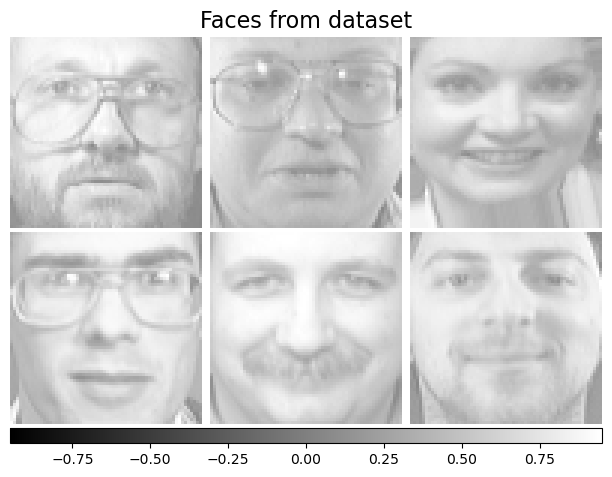

In [2]:
## set random state
rng = RandomState(0)


## import face data and convert to triplet dataset
faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=rng)
n_samples, n_features = faces.shape

rows, cols = np.nonzero(faces)
X = np.column_stack((rows, cols))
y = faces[rows, cols]


## define a face-visualization function 
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)

def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()


## show some faces
plot_gallery("Faces from dataset", faces[:n_components])

In [3]:
## solve nmf via rehline
nmf_rehline = plqMF_Ridge(C=0.0003,
                          biased=False,
                          n_users=n_samples, 
                          n_items=n_features, 
                          rank=n_components, 
                          loss={'name':'mse'}, 
                          constraint_user=[{'name': '>=0'}],
                          constraint_item=[{'name': '>=0'}],
                          verbose=1,
                          max_iter_CD=5,
                          random_state=0,
                          tol=0.01)

nmf_rehline.fit(X, y)

Iteration    Average Loss(mse)    Objective Function  
1            0.020348             18.630042           
2            0.012533             12.627574           
3            0.010705             10.203743           
4            0.009903             8.819946            
5            0.009485             7.921505            


,n_users,400
,n_items,4096
,loss,{'name': 'mse'}
,biased,False
,constraint_user,[{'name': '>=0'}]
,constraint_item,[{'name': '>=0'}]
,rank,6
,C,0.0003
,rho,0.5
,init_mean,0.0
,init_sd,0.1


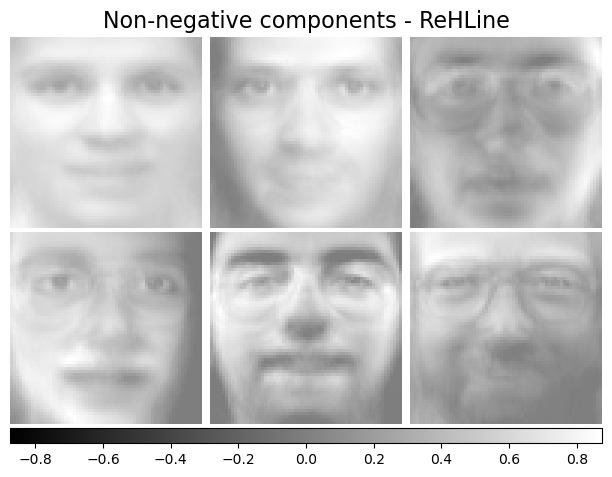

In [4]:
## check eigen faces
plot_gallery("Non-negative components - ReHLine", np.transpose(nmf_rehline.Q))